## Прогнозирование стоимости автомобиля по VIN-коду

**Задача: с помощью регулярных выражений обработать данные с внешнего файла в формате .txt и на основе обработанных данных построить модель для предсказания рыночной цены автомобиля**

VIN состоит из 17 знаков:

1-3 - производитель
4 - система подголовников
5-7 - модель
8 - двигатель
9 - контрольный знак
10 - год
11 - завод
12-17 - серийный номер

In [1]:
import re
import pandas as pd
import codecs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor, Pool, cv

In [2]:
# константа
RANDOM = 444

### Загрузка  и парсинг данных

In [3]:
# подгружаем файл, использую библиотек codecs для подгрузки в utf-8 формате

with codecs.open('vin_ford_train.txt', 'r',"utf_8_sig" ) as f:
    ford_vin = f.read()

In [4]:
# проверка, что файл подгрузился.
ford_vin[:200]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMD'

**Расшифровка vin-кода (wmi-идетификатора) для автомобилей FORD**

In [5]:
ford_wmi = {
    'AFA': 'Ford Motor Company of Southern Africa & Samcor',
    'AFB': 'Mazda BT-50 made by Ford Motor Company of Southern Africa',
    'JC0': 'Ford brand cars made by Mazda',
    'JC2': 'Ford Courier made by Mazda',
    'KNJ': 'Ford Festiva & Aspire made by Kia',
    'LJX': 'JMC Ford',
    'LVS': 'Changan Ford & Changan Ford Mazda',
    'MAJ': 'Ford India',
    'MNB': 'Ford Thailand',
    'NM0': 'Ford Otosan',
    'PE1': 'Ford Motor Company Philippines',
    'PE3': 'Mazda Philippines made by Ford Motor Company Philippines',
    'PR8': 'Ford',
    'LFA': 'Ford Lio Ho Motor Co Ltd. old designation',
    'RHA': 'Ford Lio Ho Motor Co Ltd. new designation',
    'RL0': 'Ford Vietnam',
    'SBC': 'Iveco Ford Truck',
    'SFA': 'Ford UK',
    'VSK': 'Nissan Motor Iberica SA, Nissan passenger car/MPV/van/SUV/pickup & Ford Maverick 1993–1999',
    'VS6': 'Ford Spain',
    'WF0': 'Ford Germany',
    'X9F': 'Ford Motor Company ZAO',
    'Z6F': 'Ford Sollers (Russia)',
    '1FA': 'Ford car',
    '1FB': 'Ford "bus" (van with more than 3 rows of seats)',
    '1FC': 'Ford stripped chassis made by Ford',
    '1FD': 'Ford incomplete vehicle',
    '1FM': 'Ford MPV/SUV',
    '1FT': 'Ford truck',
    '1F1': 'Ford SUV - Limousine (through 2009)',
    '1F6': 'Ford stripped chassis made by Detroit Chassis LLC',
    '1ZV': 'Ford made by AutoAlliance International',
    '2FA': 'Ford car',
    '2FM': 'Ford MPV/SUV',
    '2FT': 'Ford truck',
    '3FA': 'Ford car',
    '3FC': 'Ford stripped chassis made by Ford & IMMSA',
    '3FE': 'Ford Mexico',
    '3FM': 'Ford MPV/SUV',
    '3FN': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (truck)',
    '3FR': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (incomplete vehicle)',
    '3FT': 'Ford truck',
    '4F2': 'Mazda SUV made by Ford',
    '4F4': 'Mazda truck made by Ford',
    '4N2': 'Nissan Quest made by Ford',
    '5LD': 'Ford & Lincoln incomplete vehicle – limousine (2010–2014)',
    '6F1': 'Ford',
    '6FP': 'Ford Australia',
    '7A5': 'Ford New Zealand',
    '8AF': 'Ford Argentina',
    '9BF': 'Ford Brazil',
}

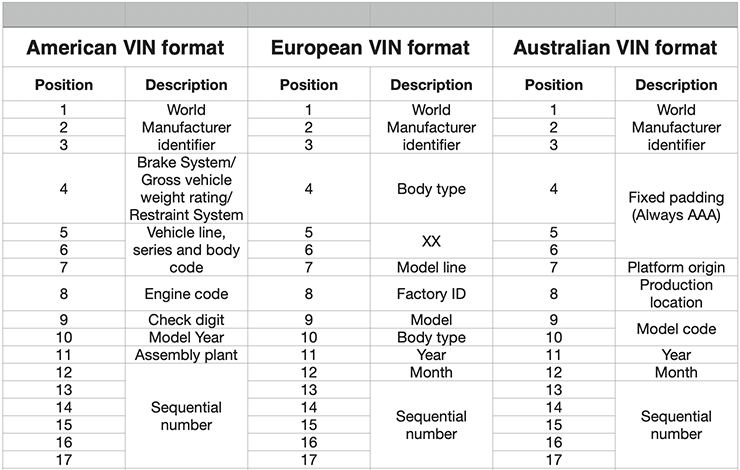

**Далее нужно распасить текст, чтобы с ним можно было работать. Для этого используем регулярные выражения.**

**Заметно, что в тексте попадается "мусор", который нам будет не нужен.**

In [6]:
# разрешённые символы в vin-формате

allowed = r'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

In [7]:
# создаём шаблон для парсинга
wmi = f'(?P<wmi>[{allowed}]{{3}})'     # 1-3
brake = f'(?P<brake>[{allowed}])'      # 4
model = f'(?P<model>[{allowed}]{{3}})' # 5-7
engine = f'(?P<engine>[{allowed}])'    # 8
check = f'(?P<check>[{allowed}])'      # 9
year = f'(?P<year>[{allowed}])'        # 10
plant = f'(?P<plant>[{allowed}])'      # 11
vis = f'(?P<vis>[{allowed}]{{3}}\\d+)\\:'  # 12 -17
price = f'(?P<price>\d+)'              # цена

In [8]:
# собираем шаблоны в один
vin = f'{wmi}{brake}{model}{engine}{check}{year}{plant}{vis}{price}'

In [9]:
# парсим текст
vin_re = re.compile(vin)
vin_re.findall(ford_vin[:200])

[('2FM', 'D', 'K3J', 'C', '4', 'B', 'B', 'A41556', '12500'),
 ('3FA', '6', 'P0H', '7', '5', 'E', 'R', '208976', '14500'),
 ('3FA', 'H', 'P08', 'Z', '1', '7', 'R', '268380', '1300'),
 ('1FM', 'C', 'U0G', 'X', '3', 'D', 'U', 'C59421', '15200'),
 ('1FA', 'H', 'P2E', '8', '9', 'D', 'G', '119368', '11600'),
 ('1FM', '5', 'K8D', '8', '2', 'D', 'G', 'A16143', '26400'),
 ('1FT', 'F', 'W1C', 'F', 'X', 'C', 'F', 'C23663', '14000')]

**Лишние слова не заватываются**

In [10]:
# функция превращения данных в датафрейм
def decode_vin(s: str) -> pd.DataFrame :
    return pd.DataFrame([x.groupdict() for x in vin_re.finditer(s)])

In [11]:
# собираем данные в таблицу
df = decode_vin(ford_vin)
df.head()

,wmi,brake,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


**Получаем инофрмацию о датафрейме**

In [12]:
# вывод информации о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wmi     71884 non-null  object
 1   brake   71884 non-null  object
 2   model   71884 non-null  object
 3   engine  71884 non-null  object
 4   check   71884 non-null  object
 5   year    71884 non-null  object
 6   plant   71884 non-null  object
 7   vis     71884 non-null  object
 8   price   71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


**Пропусков не обнаружено**

**Столбец с серийным номеров автомобиля 'vis' не информативен, удалим этот столбец**

In [13]:
df = df.drop('vis', axis=1)

**Цену и переведём в формат int**

In [14]:
# изменяем тип данных колонки с ценой на int16
df['price'] = df['price'].astype(np.uint16)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wmi     71884 non-null  object
 1   brake   71884 non-null  object
 2   model   71884 non-null  object
 3   engine  71884 non-null  object
 4   check   71884 non-null  object
 5   year    71884 non-null  object
 6   plant   71884 non-null  object
 7   price   71884 non-null  uint16
dtypes: object(7), uint16(1)
memory usage: 4.0+ MB


In [15]:
# проверка изменений
df.head()

,wmi,brake,model,engine,check,year,plant,price
0,2FM,D,K3J,C,4,B,B,12500
1,3FA,6,P0H,7,5,E,R,14500
2,3FA,H,P08,Z,1,7,R,1300
3,1FM,C,U0G,X,3,D,U,15200
4,1FA,H,P2E,8,9,D,G,11600


**Построим гистрограмму распределения цен**

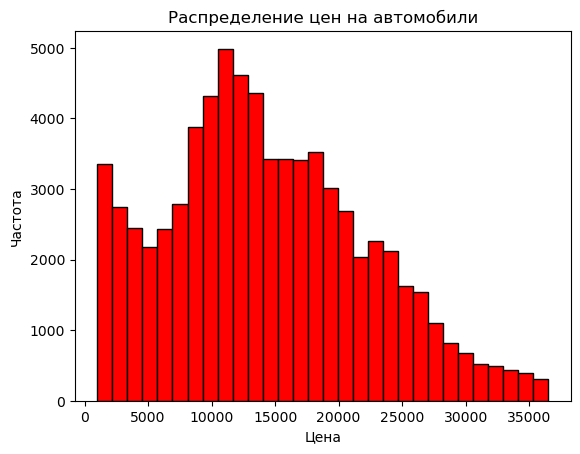

In [16]:
plt.hist(df['price'], bins=30, color='red', edgecolor='black')

plt.xlabel('Цена')
plt.ylabel('Частота')
plt.title('Распределение цен на автомобили')

plt.show()

**Распределение выглдядит нормальным с увеличенной долей автомобилей в нижнем ценовом сегменте, данные подходят для обучения модели**

### Обучение модели

**Разделим данные на обучающую и тренировочную выборки в соотношении 4:1**

In [17]:
# разделяем датасет на тренировочную и тестовую выборки
X, y = train_test_split(df, test_size = 0.20, random_state = RANDOM)

In [18]:
# Разделение признаков на обучающие и целевые
X_train = X.drop(['price'], axis = 1)
y_train = X['price']
X_test = y.drop(['price'], axis = 1)
y_test = y['price']

**Закодируем категориальные признаки с помощью OneHotEncoder, столбец 'check' также считаем категориальным**

In [19]:
# Список категориальных признаков, которые нужно преобразовать
ohe_features = ['wmi', 'brake', 'model', 'engine', 'year', 'plant', 'check']

# Созданём экземпляр OneHotEncoder 
ohe_encoder = OneHotEncoder(drop="first", sparse=False)

# обучили на полном датафрейме 
X_ohe = df.copy()
ohe_encoder.fit(X_ohe[ohe_features])

# применили к тренировочной выборке
X_temp = ohe_encoder.transform(X_train[ohe_features])
# добавляем новые признаки и удаляем старые
X_train[ohe_encoder.get_feature_names_out()] = X_temp
X_train.drop(ohe_features, axis=1, inplace=True) 

# обученный на полной выборке энкодер применили к тестовой выборке
X_temp = ohe_encoder.transform(X_test[ohe_features])
# добавляем новые признаки и удаляем старые
X_test[ohe_encoder.get_feature_names_out()] = X_temp
X_test.drop(ohe_features, axis=1, inplace=True)  # удалили старые признаки

C:\Users\Shaman\AppData\Local\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[ohe_encoder.get_feature_names_out()] = X_temp
C:\Users\Shaman\AppData\Local\Temp\ipykernel_13812\1508630966.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

In [20]:
# смотрим на результат

X_train.head()

,wmi_1FB,wmi_1FD,wmi_1FM,wmi_1FT,wmi_1ZV,wmi_2FA,wmi_2FM,wmi_2FT,wmi_3FA,wmi_3FT,...,check_1,check_2,check_3,check_4,check_5,check_6,check_7,check_8,check_9,check_X
65204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40661,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
49868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
68064,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
51432,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
# смотрим на результат
X_test.head()

,wmi_1FB,wmi_1FD,wmi_1FM,wmi_1FT,wmi_1ZV,wmi_2FA,wmi_2FM,wmi_2FT,wmi_3FA,wmi_3FT,...,check_1,check_2,check_3,check_4,check_5,check_6,check_7,check_8,check_9,check_X
12011,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18181,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66328,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23029,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Создание объекта KFold для кросс-валидации 
kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM)

**Обучим базовую модель для сравнения**

In [23]:
strategies = ['mean', 'median']
for strat in strategies:
    dummy = DummyRegressor(strategy=strat)

    dummy.fit(X_train, y_train)
    dummy_predictions = dummy.predict(X_test)


    dummy_score= mean_absolute_error(y_test, dummy_predictions)
    print("RMSE: {:.2f}".format(mean_squared_error(y_test, dummy_predictions)))
    print()

RMSE: 61204256.27

RMSE: 62114692.69



**Обучим модель линейной регресии**

In [24]:
%%time
model = Ridge() # объявление модели
model.fit(X_train, y_train)

scores = cross_val_score(model, 
                         X_train,
                         y_train,
                         cv=5, 
                         scoring='neg_mean_squared_error')

print(f'Среднеквадратичная ошибка (RMSE) модели: {sqrt(-scores.mean()):.2f}')

Среднеквадратичная ошибка (RMSE) модели: 2879.85
CPU times: total: 14.5 s
Wall time: 4.74 s


**Обучим модель с градиентным бустингом, CatBoost**

In [25]:
%%time
# параметры модели
params = {
    'learning_rate': 0.3,
    'loss_function': 'RMSE'
}

# данные для валидации
train_pool = Pool(data=X_train, label=y_train) 

test_pool = Pool(data=X_test, label=y_test)

# обучение модели
model_CatBoost = CatBoostRegressor(**params)
model_CatBoost.fit(X_train, y_train)
# оценка модели
cv_data = cv(train_pool,
             params=params,
             fold_count=5,
             shuffle=True,
             partition_random_seed=RANDOM,
             verbose=False)

rmse_mean = cv_data['test-RMSE-mean'].mean()

# среднее значение RMSE
print(f'Среднеквадратичная ошибка RMSE по кросс-валидации: {rmse_mean:.2f}')

0:	learn: 6686.7629158	total: 151ms	remaining: 2m 30s
1:	learn: 5936.9643763	total: 166ms	remaining: 1m 23s
2:	learn: 5457.8838225	total: 184ms	remaining: 1m 1s
3:	learn: 5102.2229907	total: 200ms	remaining: 49.7s
4:	learn: 4816.6303789	total: 216ms	remaining: 42.9s
5:	learn: 4608.6015613	total: 231ms	remaining: 38.2s
6:	learn: 4390.4743296	total: 246ms	remaining: 35s
7:	learn: 4254.5838566	total: 262ms	remaining: 32.5s
8:	learn: 4094.1282336	total: 277ms	remaining: 30.5s
9:	learn: 4004.6942069	total: 291ms	remaining: 28.8s
10:	learn: 3919.3183019	total: 306ms	remaining: 27.5s
11:	learn: 3847.1385804	total: 320ms	remaining: 26.4s
12:	learn: 3794.5498832	total: 335ms	remaining: 25.4s
13:	learn: 3742.7712131	total: 350ms	remaining: 24.6s
14:	learn: 3694.9967184	total: 365ms	remaining: 24s
15:	learn: 3664.0802777	total: 379ms	remaining: 23.3s
16:	learn: 3629.0345244	total: 395ms	remaining: 22.8s
17:	learn: 3595.6152612	total: 409ms	remaining: 22.3s
18:	learn: 3570.6914553	total: 423ms	rem

167:	learn: 2781.5342490	total: 2.48s	remaining: 12.3s
168:	learn: 2781.3467026	total: 2.49s	remaining: 12.2s
169:	learn: 2780.7011172	total: 2.5s	remaining: 12.2s
170:	learn: 2780.0622730	total: 2.52s	remaining: 12.2s
171:	learn: 2779.3840355	total: 2.53s	remaining: 12.2s
172:	learn: 2777.2008590	total: 2.54s	remaining: 12.1s
173:	learn: 2776.5595091	total: 2.55s	remaining: 12.1s
174:	learn: 2776.2061749	total: 2.57s	remaining: 12.1s
175:	learn: 2775.9146999	total: 2.58s	remaining: 12.1s
176:	learn: 2774.8259058	total: 2.59s	remaining: 12.1s
177:	learn: 2773.8110498	total: 2.6s	remaining: 12s
178:	learn: 2773.0637262	total: 2.62s	remaining: 12s
179:	learn: 2772.0532020	total: 2.63s	remaining: 12s
180:	learn: 2771.4201710	total: 2.64s	remaining: 12s
181:	learn: 2770.4737690	total: 2.66s	remaining: 11.9s
182:	learn: 2769.9585208	total: 2.67s	remaining: 11.9s
183:	learn: 2768.8220430	total: 2.69s	remaining: 11.9s
184:	learn: 2768.2564177	total: 2.7s	remaining: 11.9s
185:	learn: 2766.2406

331:	learn: 2697.3229951	total: 4.8s	remaining: 9.66s
332:	learn: 2696.8103734	total: 4.82s	remaining: 9.64s
333:	learn: 2696.4597674	total: 4.83s	remaining: 9.63s
334:	learn: 2696.4240637	total: 4.84s	remaining: 9.61s
335:	learn: 2696.2634690	total: 4.86s	remaining: 9.6s
336:	learn: 2696.1030394	total: 4.87s	remaining: 9.58s
337:	learn: 2695.6966490	total: 4.88s	remaining: 9.56s
338:	learn: 2695.4400030	total: 4.9s	remaining: 9.55s
339:	learn: 2695.1285777	total: 4.91s	remaining: 9.53s
340:	learn: 2694.7215034	total: 4.92s	remaining: 9.51s
341:	learn: 2694.4009729	total: 4.94s	remaining: 9.5s
342:	learn: 2693.9522131	total: 4.95s	remaining: 9.48s
343:	learn: 2693.5022627	total: 4.96s	remaining: 9.47s
344:	learn: 2693.1749725	total: 4.98s	remaining: 9.45s
345:	learn: 2692.8314115	total: 4.99s	remaining: 9.44s
346:	learn: 2692.3130688	total: 5.01s	remaining: 9.42s
347:	learn: 2692.1229554	total: 5.02s	remaining: 9.4s
348:	learn: 2691.3493789	total: 5.03s	remaining: 9.39s
349:	learn: 269

487:	learn: 2655.9088529	total: 6.91s	remaining: 7.25s
488:	learn: 2655.5624621	total: 6.92s	remaining: 7.24s
489:	learn: 2655.3933563	total: 6.94s	remaining: 7.22s
490:	learn: 2655.0954117	total: 6.95s	remaining: 7.21s
491:	learn: 2654.9559992	total: 6.96s	remaining: 7.19s
492:	learn: 2654.9367627	total: 6.98s	remaining: 7.17s
493:	learn: 2654.4338620	total: 6.99s	remaining: 7.16s
494:	learn: 2654.2014803	total: 7s	remaining: 7.14s
495:	learn: 2654.1446807	total: 7.02s	remaining: 7.13s
496:	learn: 2654.1265805	total: 7.03s	remaining: 7.12s
497:	learn: 2654.0117245	total: 7.04s	remaining: 7.1s
498:	learn: 2653.8902440	total: 7.06s	remaining: 7.09s
499:	learn: 2653.4161494	total: 7.07s	remaining: 7.07s
500:	learn: 2653.1985544	total: 7.08s	remaining: 7.06s
501:	learn: 2653.1155984	total: 7.1s	remaining: 7.04s
502:	learn: 2652.9842232	total: 7.11s	remaining: 7.03s
503:	learn: 2652.7999761	total: 7.12s	remaining: 7.01s
504:	learn: 2652.7846717	total: 7.14s	remaining: 7s
505:	learn: 2652.4

637:	learn: 2627.3960136	total: 9.05s	remaining: 5.14s
638:	learn: 2627.3256659	total: 9.07s	remaining: 5.12s
639:	learn: 2627.2262500	total: 9.08s	remaining: 5.11s
640:	learn: 2627.2159382	total: 9.09s	remaining: 5.09s
641:	learn: 2627.0567621	total: 9.11s	remaining: 5.08s
642:	learn: 2626.8302796	total: 9.12s	remaining: 5.06s
643:	learn: 2626.6005422	total: 9.13s	remaining: 5.05s
644:	learn: 2626.4715807	total: 9.15s	remaining: 5.03s
645:	learn: 2626.3885914	total: 9.16s	remaining: 5.02s
646:	learn: 2626.0347264	total: 9.17s	remaining: 5s
647:	learn: 2625.9713590	total: 9.19s	remaining: 4.99s
648:	learn: 2625.9588111	total: 9.2s	remaining: 4.97s
649:	learn: 2625.8412459	total: 9.21s	remaining: 4.96s
650:	learn: 2625.7750694	total: 9.22s	remaining: 4.94s
651:	learn: 2625.5966425	total: 9.24s	remaining: 4.93s
652:	learn: 2625.5802920	total: 9.25s	remaining: 4.91s
653:	learn: 2625.4008340	total: 9.26s	remaining: 4.9s
654:	learn: 2625.1695758	total: 9.28s	remaining: 4.88s
655:	learn: 262

792:	learn: 2607.0925106	total: 11.2s	remaining: 2.92s
793:	learn: 2606.9997276	total: 11.2s	remaining: 2.9s
794:	learn: 2606.8710007	total: 11.2s	remaining: 2.89s
795:	learn: 2606.6709587	total: 11.2s	remaining: 2.87s
796:	learn: 2606.5808065	total: 11.2s	remaining: 2.86s
797:	learn: 2606.4689913	total: 11.2s	remaining: 2.84s
798:	learn: 2606.3977580	total: 11.3s	remaining: 2.83s
799:	learn: 2606.3020084	total: 11.3s	remaining: 2.81s
800:	learn: 2606.0941645	total: 11.3s	remaining: 2.8s
801:	learn: 2605.9603561	total: 11.3s	remaining: 2.79s
802:	learn: 2605.8209134	total: 11.3s	remaining: 2.77s
803:	learn: 2605.6984835	total: 11.3s	remaining: 2.76s
804:	learn: 2605.5935261	total: 11.3s	remaining: 2.74s
805:	learn: 2605.5126536	total: 11.3s	remaining: 2.73s
806:	learn: 2605.4524985	total: 11.4s	remaining: 2.71s
807:	learn: 2605.3868368	total: 11.4s	remaining: 2.7s
808:	learn: 2605.2694922	total: 11.4s	remaining: 2.69s
809:	learn: 2605.0302269	total: 11.4s	remaining: 2.67s
810:	learn: 2

955:	learn: 2589.3569355	total: 13.5s	remaining: 620ms
956:	learn: 2589.3526400	total: 13.5s	remaining: 606ms
957:	learn: 2589.2408931	total: 13.5s	remaining: 591ms
958:	learn: 2589.0284134	total: 13.5s	remaining: 577ms
959:	learn: 2589.0165134	total: 13.5s	remaining: 563ms
960:	learn: 2588.8836796	total: 13.5s	remaining: 549ms
961:	learn: 2588.8264188	total: 13.5s	remaining: 535ms
962:	learn: 2588.7738282	total: 13.6s	remaining: 521ms
963:	learn: 2588.7115734	total: 13.6s	remaining: 507ms
964:	learn: 2588.6134897	total: 13.6s	remaining: 493ms
965:	learn: 2588.5798214	total: 13.6s	remaining: 478ms
966:	learn: 2588.2905926	total: 13.6s	remaining: 464ms
967:	learn: 2588.2765638	total: 13.6s	remaining: 450ms
968:	learn: 2588.1642395	total: 13.6s	remaining: 436ms
969:	learn: 2587.9608048	total: 13.6s	remaining: 422ms
970:	learn: 2587.6840365	total: 13.7s	remaining: 408ms
971:	learn: 2587.6424293	total: 13.7s	remaining: 394ms
972:	learn: 2587.6379813	total: 13.7s	remaining: 380ms
973:	learn

**Модели Ridge и CatBoost показали схожий результат 2879.85 и 2875.80 соотвественно, что лучше чем dummy-модель с её 61204256.27**

### Предсказание модели на тестовой выборке

In [26]:
predict = model_CatBoost.predict(test_pool)
rmae = sqrt(mean_squared_error(y_test, predict))

print(f'RMSE на тестовых данных: {rmae}')

RMSE на тестовых данных: 2805.616522903539


**Значенме метрики на тестовых данных, близко к значению метрики на тренировочных данных, значит модель смогла избежать переобучения**

### Вывод

**Данная работа была напралена на освоение регулярных выражений. С помощью этого иснтрумента мы смогли обработать данные по VIN-кодам автомобилей. На обработанных данных смогли обучить модели по предсказанию цены автомобиля на основе VIN-кодов. Регулярные выражения оказались довольно удоюным инстурментом для обработки повторяющихся данных в текстовом виде.**

**Далее можно создать функцию или класс, которая будет по введённому VIN-коду выдачать модель автомобиля и предсказывать его предположительную стоимость**